# **Discogs Data Analysis**

This notebook analyzes the newest item listings on the Discogs Marketplace and compares them with their average prices in hopes of answering the question: is there a significant difference these listed prices and their average prices? 

This notebook doesn't explore the decisions behind a buyer's decision to buy or not buy a particular record, but it instead looks at any given listing on the Marketplace and sees if they're valued reasonably to other similar listings for that particular item. 

---

# Setting up

Installing the client package, importing other packages, authenticating Discogs user to send API requests

Request Token URL: 	https://api.discogs.com/oauth/request_token

Authorize URL: 	https://www.discogs.com/oauth/authorize

Access Token URL: 	https://api.discogs.com/oauth/access_token

In [0]:
!pip install discogs_client

  Created wheel for discogs-client: filename=discogs_client-2.2.2-cp36-none-any.whl size=12171 sha256=5cae654fd6e7943f9f3d03ff73c8ce1a0bbc80018e763d96df3be142737fd309
  Stored in directory: /root/.cache/pip/wheels/19/a4/51/f48085cd2748dfdf2e5ec9cb445687e58001022cb66c359bdb
Successfully built discogs-client


In [0]:
#!/usr/bin/env python
#
# This illustrates the call-flow required to complete an OAuth request
# against the discogs.com API, using the discogs_client libary.
# The script will download and save a single image and perform and
# an API search API as an example. See README.md for further documentation.

import sys
import discogs_client
from discogs_client.exceptions import HTTPError

import requests
from bs4 import BeautifulSoup
from scipy import stats
import seaborn as sns
import warnings
from matplotlib import pyplot as plt 

warnings.filterwarnings('ignore')
sns.set()

# Your consumer key and consumer secret generated and provided by Discogs.
# See http://www.discogs.com/settings/developers . These credentials
# are assigned by application and remain static for the lifetime of your discogs
# application. the consumer details below were generated for the
# 'discogs-oauth-example' application.
# NOTE: these keys are typically kept SECRET. I have requested these for
# demonstration purposes.

# SECRET CONUMER KEYS UNIQUE TO DATA ANALYIS APP
print('Discogs user hayleyhayleyb is the only person with access to the consumer and consumer secret keys.')
consumer_key = input('Consumer key: ')
consumer_secret = input('Consumer secret key: ')

# A user-agent is required with Discogs API requests. Be sure to make your
# user-agent unique, or you may get a bad response.
user_agent = 'Discogs User hayleyhayleyb\'s Data Analysis'

# instantiate our discogs_client object.
discogsclient = discogs_client.Client(user_agent)

# prepare the client with our API consumer data.
discogsclient.set_consumer_key(consumer_key, consumer_secret)
token, secret, url = discogsclient.get_authorize_url()

print (' == Request Token == ')
print ('    * oauth_token        = {0}'.format(token))
print ('    * oauth_token_secret = {0}'.format(secret))

# Prompt your user to "accept" the terms of your application. The application
# will act on behalf of their discogs.com account.
# If the user accepts, discogs displays a key to the user that is used for
# verification. The key is required in the 2nd phase of authentication.
print ('Please browse to the following URL {0}'.format(url))

accepted = 'n'
while accepted.lower() == 'n':
    print
    accepted = input('Have you authorized me at {0} [y/n] :'.format(url))


# Waiting for user input. Here they must enter the verifier key that was
# provided at the unqiue URL generated above.
oauth_verifier = input('Verification code :')

try:
    access_token, access_secret = discogsclient.get_access_token(oauth_verifier)
except HTTPError:
    print ('Unable to authenticate.')
    sys.exit(1)

# fetch the identity object for the current logged in user.
user = discogsclient.identity()

print (' == User ==')
print ('    * username           = {0}'.format(user.username))
print ('    * name               = {0}'.format(user.name))
print (' == Access Token ==')
print ('    * oauth_token        = {0}'.format(access_token))
print ('    * oauth_token_secret = {0}'.format(access_secret))
print (' Authentication complete. Future requests will be signed with the above tokens.')

# Web scraping the Marketplace listings

Search through the Discogs Marketplace to get the price of the 25 most recent listings

Get a dictionary `price_list` of key identifying information describing each item

In [0]:
# this code block gets the HTML of the entire listings webpage
url = 'https://www.discogs.com/sell/list'
response = requests.get(url)
data = response.text
soup = BeautifulSoup(data, 'html.parser')
# print(soup.prettify())
print('done')

done


In [0]:
# returns the total price of an item in USD
# up to 3 lines in an item's listing: listed price, shipping info, {total price}
# listed price = USD or other currency
# shipping info = flat or calculated
# {total price} = calculated or estimated calculation or not given

# returns numerical value for total price given a certain item
def total_price(row):
  total = ''
  converted_price = ''
  listed_price = row.find('span', class_='price')

  # handling all possible currency formats and styles
  if listed_price.get_text()[0] == '$': # cases for usd
    shipping_price = row.find('span', class_='item_shipping')
    if '$' in shipping_price.get_text():  # if USD and has flat rate shipping
      total = row.find('span', class_='converted_price').get_text()[13:-6]
    else:   # if USD and variable shipping rate
      total = listed_price.get_text()[1:]
  else:                                 # cases for other currency
    shipping_price = row.find('span', class_='hide_mobile')
    try:  # for international flat rate shipping, then the total will just be the converted price
      shipping_price.get_text()
      converted_price = row.find('span', class_='converted_price')
      total = converted_price.get_text()[18:-6]
    except AttributeError:  # for international variable rate shipping, total is estimated converted price and shipping
      converted_price = row.find('span', class_='converted_price')
      total = converted_price.get_text()[7:]

  try:
    total = float(total)
  except:
    total = total.split('.')
    total = total[0][1:] + total[1]
    total = float(total)
  return total

In [0]:
# extracts key identifying information from each listing
main_page = soup.find('div', class_='aside_off_canvas') # from the main body of the webpage,
content = main_page.find('div', id='page_content')
main_table = content.find('table', class_='mpitems')
table = main_table.find('tbody')
items = table.find_all('tr', class_='shortcut_navigable') # find the table of the listings

price_list = {} # key=label and catno : value=[label, catno, title, total_price]
for row in items:
  names = row.find('a', class_='item_description_title')

  label_cat = row.find('p', class_='label_and_cat')
  cat_num = label_cat.find('span', class_='item_catno')
  label = label_cat.find('a')
  search_item = label.get_text() + ' ' + cat_num.get_text()

  prices = row.find('td', class_='item_price')
  price_selling = prices.find('span', class_='price')

  total = total_price(prices)

  # code block outputs this price_list dictionary
  price_list[search_item] = [label.get_text(), cat_num.get_text(), names.get_text(), total]

# looks at the newest listings from the Marketplace and extracts category number and selling price for each item
for i in price_list:
  print(i, '\t\t', price_list[i])

Blue Note TOCJ-8544 		 ['Blue Note', 'TOCJ-8544', 'Johnny Griffin - Introducing Johnny Griffin (CD, Album, Mono, Ltd, RE, RM)', 83.03]
Virgin 613 232 		 ['Virgin', '613 232', 'Azra (2) - Only Love Can Help (12")', 19.47]
Chiaroscuro Records CR-171 		 ['Chiaroscuro Records', 'CR-171', 'Bob Wilber And The Scott Hamilton Quartet - Bob Wilber And The Scott Hamilton Quartet (LP, Album)', 8.98]
Peaceville CDVILEF403 		 ['Peaceville', 'CDVILEF403', 'Katatonia - Dead End Kings (CD, Album, O-C)', 8.73]
Island Records ILPS 9801 		 ['Island Records', 'ILPS 9801', 'Robert Palmer - Riptide (LP, Album)', 46.91]
Noise Records N 0325-2 		 ['Noise Records', 'N 0325-2', 'Celtic Frost - Morbid Tales (CD, Album, RE, RM)', 19.64]
Underyourskin Records UYSR035 		 ['Underyourskin Records', 'UYSR035', 'Crussen - Breakfast In The Hut EP (12", EP)', 16.36]
Finders Keepers Records FKR048LP 		 ['Finders Keepers Records', 'FKR048LP', 'Don Gere - Werewolves On Wheels (Original Motion Picture Soundtrack) (LP, Album,

Text(0, 0.5, 'Frequency of price')

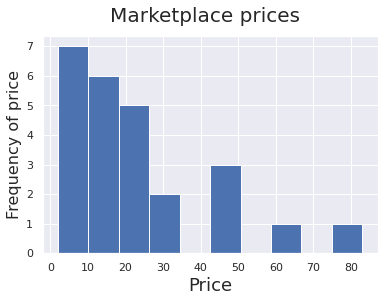

In [0]:
# create a distribution plot of the prices of the new listings
# prices usually average anywhere between $0-$100 
prices = []
for i in price_list:
  prices.append(price_list[i][3])

fig = plt.figure()
plt.hist(prices)
fig.suptitle('Marketplace Prices', fontsize=20) 
plt.xlabel('Price', fontsize=18) 
plt.ylabel('Frequency of Price', fontsize=16)

# AT LEAST ONE VISUALIZATION

# Run a search through each newly listed item in the marketplace
Use search keywords from `price_list` to extract `ReleaseID`s

Get a dictionary of lists, `release_dict` where the key is `ReleaseID` and the value is a list that retain the search keywords from the last codeblock

In [0]:
# getting a dictionary of release IDs associated with each newly listed marketplace item
# release IDs are needed to look for the marketplace's other listings for the same item
release_dict = {}
for item in price_list: # item is each new listing
  # test is MixedPaginatedList, have to iterate through to get attributes
  test = discogsclient.search(price_list[item][2],label=price_list[item][0], catno=price_list[item][1], type='release')
  for i in test:
    #print(i)
    release_dict[i.id] = price_list[item]

release_dict # releaseID: [label, catno, title, price]

{190510: ['Ariola',
  '601 054',
  'Imagination - New Dimension (12", Maxi)',
  2.17],
 425362: ['Ariola',
  '601 054',
  'Imagination - New Dimension (12", Maxi)',
  2.17],
 457264: ['Gordy',
  'TMG 1309',
  'Mary Jane Girls - All Night Long (7", Single)',
  9.0],
 471426: ['Island Records',
  'ILPS 9801',
  'Robert Palmer - Riptide (LP, Album)',
  46.91],
 727603: ['ATCO Records',
  '756791758-2',
  'Pantera - Vulgar Display Of Power (CD, Album, RE)',
  12.9],
 750285: ['Decca', 'DL 79173', 'Alfred Newman - Airport (LP, Album)', 13.49],
 867103: ['Tippermusic',
  'TIPP004V',
  'Tipper - Unlock The Geometry / Deal With It (12")',
  61.73],
 917229: ['RAS Records Inc.',
  'RASMP 3156',
  'Sizzla - Burning Up (CD, Album)',
  3.82],
 1335645: ['Injection Disco Dance Label',
  '234.839',
  'Angie Dylan - Love On The Rebound (12")',
  15.27],
 1450918: ['Island Records',
  'ILPS 9801',
  'Robert Palmer - Riptide (LP, Album)',
  46.91],
 1625054: ['Chiaroscuro Records',
  'CR-171',
  'Bob W

# Extract each release's other listings

Use the `ReleaseID`s to look through the Marketplace for all other listings of the release, extract price information about the other listings

In [0]:
#@title Default title text
# web scraping through the release page
# want lowest and median prices of past sales
# will also want to create an array of all listed prices for t-test
# these will be returned in a dictionary

def release_page_stats(release_id):
  url = 'https://www.discogs.com/sell/release/' + str(release_id)
  response = requests.get(url)
  data = response.text
  soup = BeautifulSoup(data, 'html.parser')
  # print(soup.prettify())
  
  stats_table = soup.find('div', class_='right')
  
  lists = stats_table.find('div', class_='toggle_section_content')
  last_sold = lists.find_all('li')

  statistics = {}
  for i in last_sold:                         # for each statistic on the top right corner of the release page, get the lowest, median, and highest prices.
    item = i.get_text().strip().split('\n')   # if this release has never been sold before, don't cast it to a float value
    if item[0] == 'Lowest:' or item[0] == 'Median:' or item[0] == 'Highest:': # most important attributes of release listing
      if '-' not in item[1][17:]:
        statistics[item[0][:-1]] = float(item[1][17:])  # values have 16 leading spaces and need to be converted to float
      else:
        statistics[item[0][:-1]] = item[1][17:] + "EMPTY"
    
    #else:
    #  statistics[item[0][:-1]] = item[1]
  #statistics['Lowest Current Price:'] = release_stats['lowest_price']['value']

  content = soup.find('div', id='page_content')
  table = content.find('tbody')
  items = table.find_all('tr', class_='shortcut_navigable')

  listings_price_list = []
  for i in items:
    prices = i.find('td', class_='item_price')
    total = total_price(prices)
    listings_price_list.append(total)
  statistics['Other prices'] = listings_price_list
  return statistics

#stats_dict = release_page_stats(1084479) #testing the function with Loveless CD
#stats_dict

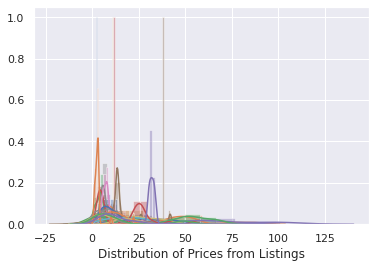

In [0]:
#sns.distplot(stats_dict['Other prices'])

for i in release_dict: # iterating through new release list
  marketplace_listings = release_page_stats(i)['Other prices']
  sns.distplot(marketplace_listings, axlabel='Distribution of Listings\' Prices') # plot distribution of stats of each new release

# Run t-tests on the items against their other listings

Iterate through the dictionary of releases pulled from the new listings on the Marketplace and run one-sample t-tests on each of them.

Most of the releases return very high p-values, suggesting that there is not a significant difference between the listed prices and the prices of their other listings. 

In [0]:
# defining a method for doing one sample t-test
def ttesting(mean, array2):
  mean_array = []
  for i in array2:
    mean_array.append(mean)
  results = stats.ttest_ind(mean_array, array2)
  results_str = str(results).split('=')

  if 'nan, pvalue=na' not in str(results):
    t_val = float(results_str[1][:4])
    p_val = float(results_str[2][:-1])
    result = []
    result.append(t_val)
    result.append(p_val)
    return result
  else: 
    return [0, 0]

# print(ttesting(6.46, stats_dict['Other prices']))

In [0]:
# iterating through the dictionary of releaseIDs, getting their respective 'other prices' list and performing the t-test on them

all_releases = []
temp = {}
good = []
for i in release_dict:
  temp = release_page_stats(i)['Other prices']
  all_releases.append(temp)
  t_test = ttesting(release_dict[i][3], temp)
  if t_test[1] < 0.05:
    good.append(i)
  print(release_dict[i][3], t_test)

print('There are', len(good), 'out of', len(all_releases), 'releases that are significantly different')

19.47 [2.72, 0.013109259561116762]
8.98 [-2.5, 0.014622842284821157]
46.91 [20.1, 4.632065029411729e-25]
46.91 [9.94, 1.000271807124188e-07]
46.91 [23.1, 1.4551295516007611e-12]
46.91 [3.43, 0.026433729508436393]
46.91 [14.3, 5.786461805775025e-16]
46.91 [21.2, 7.064256873945885e-07]
46.91 [0, 0]
46.91 [0, 0]
16.36 [-1.7, 0.16054068395444712]
49.99 [-0.9, 0.3604535982328021]
25.05 [10.0, 2.2408408159782364e-13]
3.82 [-1.7, 0.09994946203787677]
61.73 [-0.7, 0.5077845387340859]
13.19 [-1.3, 0.18128339375232763]
13.49 [6.86, 1.1983363813371501e-08]
13.49 [4.49, 0.00014987071298131418]
13.49 [-2.3, 0.08186190602743357]
9.0 [-4.4, 8.965748061699146e-05]
9.0 [0.12, 0.9042622629170529]
9.0 [-1.0, 0.3337490917841375]
22.98 [-9.3, 7.785392352638503e-07]
22.98 [-2.5, 0.01699049976939029]
22.98 [-10.0, 0.00044126921375432657]
22.98 [0, 0]
22.98 [0, 0]
2.17 [-2.7, 0.008187846502129222]
2.17 [-4.7, 1.8172093507358233e-05]
1.99 [0, 0]
1.99 [0, 0]
12.9 [10.9, 1.1441367008508523e-14]
12.9 [-0.2, 0.792

# Conclusion

What does it mean that these releases are significantly different from their average listing prices? It suggests that the listed releases are on average either much higher or much lower than their average valued price. Since the p-values are two-tailed, further analysis would be needed to determine which direction the listings fall out of the range of. 

---

This means that there is generally some fluctuation of values being set on records that is difficult to determine from just looking at the average prices on the market. There appears to be an arbitrary upper limit for the amount that an average person is willing to pay for a record, possibly determined by other factors than just the average price of other records (rarity, condition, year released, etc) that were not analyzed in this notebook. 

---

My recommendation for sellers is to add additional information about these releases to increase their value above average marketplace listings (older, more rare records in mint condition are more highly valued than newer, less rare records in good condition). This will allow buyers across the Marketplace to expect higher quality listings and in turn expect to pay higher prices. 